In [193]:
from graphMatching import *
from networkx import read_edgelist
from scipy.io import loadmat
from model import *
from utils import *

In [194]:
data = "Douban Online_Offline" # args.dataset
device = torch.device('cuda:3' if torch.cuda.is_available() else "cpu")
train_features = {}
if (data == "ACM_DBLP"):
    train_set = ["ACM", "DBLP"]
    input_dim = 17
    b = np.load('data/ACM-DBLP.npz')
    train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
    train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
    test_pairs = b['test_pairs'].astype(np.int32)
    NUM_HIDDEN_LAYERS = 12
    HIDDEN_DIM = 1024
    output_feature_size = 1024
    lr = 0.0001
    epoch = 50
elif (data == "Douban Online_Offline"):
    a1, f1, a2, f2, test_pairs = load_douban()
    f1 = f1.A
    f2 = f2.A
    train_set = ["Online", "Offline"]
    input_dim = 538
    test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
    test_pairs = test_pairs.numpy()
    train_features["Online"] = [torch.from_numpy(f1).float()]
    train_features["Offline"] = [torch.from_numpy(f2).float()]
    NUM_HIDDEN_LAYERS = 6
    HIDDEN_DIM = 512
    output_feature_size = 512
    lr = 0.0001
    epoch = 20


In [195]:
# temp = torch.from_numpy(b["x1"]).float() # G1, node attributes
temp = torch.from_numpy(f1).float()
print(temp.shape)
temp

torch.Size([3906, 538])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [196]:
# temp = torch.from_numpy(b["x2"]).float() # G2, node attributes
temp = torch.from_numpy(f2).float()
print(temp.shape)
temp

torch.Size([1118, 538])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [197]:
""" temp = b["test_pairs"]
print(temp.shape)
temp """

' temp = b["test_pairs"]\nprint(temp.shape)\ntemp '

In [198]:
test_pairs

array([[2890, 3866, 1883, ...,  583, 3904, 2746],
       [ 902,  270,  889, ...,  275,  915,  801]])

In [199]:
train_set

['Online', 'Offline']

In [200]:
encoder = "GIN"
use_input_augmentation = True
use_output_augmentation = False
print("Loading training datasets")
train_loader = {}
for dataset in train_set:
    train_loader[dataset] = [load_adj(dataset)]

train_loader

Loading training datasets


{'Online': [tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)],
 'Offline': [tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)]}

In [201]:
train_loader.keys()

dict_keys(['Online', 'Offline'])

In [202]:
temp = train_loader["Online"][0]
print(temp.shape)
temp

torch.Size([3906, 3906])


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [203]:
temp = train_loader["Offline"][0]
print(temp.shape)
temp

torch.Size([1118, 1118])


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [204]:
model = GAE(NUM_HIDDEN_LAYERS,
            input_dim,
            HIDDEN_DIM,
            output_feature_size, activation=F.relu,
            use_input_augmentation=use_input_augmentation,
            use_output_augmentation=use_output_augmentation,
            encoder=encoder).to(device)
model

GAE(
  (base_gcn): GIN(
    (in_proj): Linear(in_features=538, out_features=512, bias=True)
    (convs): ModuleList(
      (0-7): 8 x GINConv(
        (linear): Linear(in_features=1050, out_features=512, bias=True)
      )
    )
    (out_proj): Linear(in_features=4608, out_features=512, bias=True)
  )
)

In [205]:
print("Generating training features")


Generating training features


In [206]:
print("Fitting model")
# fit_GAE_real(data, len(train_set) * (1 + 1), model, epoch, train_loader, train_features, device, lr,test_pairs)
# fit_GAE_real(data, no_samples, GAE, epoch, train_loader, train_features, device, lr, test_pairs):

no_samples = len(train_set) * (1 + 1)
GAE = model
# ---

best_hitAtOne = 0
best_hitAtFive = 0
best_hitAtTen = 0
best_hitAtFifty = 0
optimizer = Adam(GAE.parameters(), lr=lr, weight_decay=5e-4)

for step in tqdm(range(epoch)):
    loss = 0
    
    for dataset in train_loader.keys():
        S = train_loader[dataset][0]
        initial_features = train_features[dataset]
        
        for i in range(len(train_loader[dataset])):
            adj_tensor = train_loader[dataset][i]
            adj = coo_matrix(adj_tensor.numpy())
            adj_norm = preprocess_graph(adj)
            pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
            norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

            adj_label = coo_matrix(S.numpy())
            adj_label = sparse_to_tuple(adj_label)

            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T),
                                                torch.FloatTensor(adj_norm[1]),
                                                torch.Size(adj_norm[2])).to(device)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T),
                                                torch.FloatTensor(adj_label[1]),
                                                torch.Size(adj_label[2])).to(device)

            initial_feature = initial_features[i].to(device)

            weight_mask = adj_label.to_dense().view(-1) == 1
            weight_tensor = torch.ones(weight_mask.size(0))
            weight_tensor[weight_mask] = pos_weight
            weight_tensor = weight_tensor.to(device)
            z = GAE(initial_feature, adj_norm)
            A_pred = torch.sigmoid(torch.matmul(z,z.t()))
            loss += norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1),
                                                        weight=weight_tensor)
    
    optimizer.zero_grad()
    loss = loss / no_samples
    loss.backward()
    optimizer.step()

    # Adjacency matrix
    keys = list(train_loader.keys())
    S1 = train_loader[keys[0]][0]
    S2 = train_loader[keys[1]][0]
    
    adj_S1 = coo_matrix(S1.numpy())
    adj_norm_1 = preprocess_graph(adj_S1)
    adj_norm_1 = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_1[0].T),
                                            torch.FloatTensor(adj_norm_1[1]),
                                            torch.Size(adj_norm_1[2])).to(device)
    adj_S2 = coo_matrix(S2.numpy())
    adj_norm_2 = preprocess_graph(adj_S2)
    adj_norm_2 = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_2[0].T),
                                            torch.FloatTensor(adj_norm_2[1]),
                                            torch.Size(adj_norm_2[2])).to(device)
    if (data == "ACM_DBLP"):
        S1_feat = train_features["ACM"][0]
        S2_feat = train_features["DBLP"][0]
    elif (data == "Douban Online_Offline"):
        S1_feat = train_features["Online"][0]
        S2_feat = train_features["Offline"][0]

    # get node embeddings
    S1_emb = GAE(S1_feat.to(device), adj_norm_1).detach()
    S2_emb = GAE(S2_feat.to(device), adj_norm_2).detach()

    D = torch.cdist(S1_emb, S2_emb, 2) # Euclidean distance
    
    # test
    
    
    if (data == "ACM_DBLP"):
        test_idx = test_pairs[:, 0].astype(np.int32)
        labels = test_pairs[:, 1].astype(np.int32)
    elif (data == "Douban Online_Offline"):
        test_idx = test_pairs[0, :].astype(np.int32)
        labels = test_pairs[1, :].astype(np.int32)
    
    """ hitAtOne = 0
    hitAtFive = 0
    hitAtTen = 0
    hitAtFifty = 0
    hitAtHundred = 0
        
    for i in range(len(test_idx)): # here
        dist_list = D[test_idx[i]]
        # print(i, test_idx[i], dist_list)
        sorted_neighbors = torch.argsort(dist_list).cpu()
        label = labels[i]
        
        # if i == 0:
        #    print(label, sorted_neighbors[0].item(), sorted_neighbors)
        #    # 6829 6829 tensor([6829, 3102,  601,  ..., 7878, 9701, 2044])
        
        for j in range(100):
            if (sorted_neighbors[j].item() == label):
                if (j == 0):
                    hitAtOne += 1
                    hitAtFive += 1
                    hitAtTen += 1
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 4):
                    hitAtFive += 1
                    hitAtTen += 1
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 9):
                    hitAtTen += 1
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 49):
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 100):
                    hitAtHundred += 1
                    break
    
    cur_hitAtOne = hitAtOne / len(test_idx)
    cur_hitAtFive = hitAtFive / len(test_idx)
    cur_hitAtTen = hitAtTen / len(test_idx)
    cur_hitAtFifty = hitAtFifty / len(test_idx)

    if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
    if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
    if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
    if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

print("The best results achieved:")
print("Hit@1: ", end="")
print(best_hitAtOne)
print("Hit@5: ", end="")
print(best_hitAtFive)
print("Hit@10: ", end="")
print(best_hitAtTen)
print("Hit@50: ", end="")
print(best_hitAtFifty) """

Fitting model


100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


In [207]:
D.shape

torch.Size([3906, 1118])

In [208]:
D

tensor([[1.8017, 1.3753, 1.7637,  ..., 1.4333, 0.3476, 2.0564],
        [2.2010, 1.8911, 2.3289,  ..., 1.9327, 2.0949, 2.4817],
        [1.8073, 1.3690, 1.7995,  ..., 1.4485, 0.3999, 2.0590],
        ...,
        [1.7043, 1.2590, 1.6889,  ..., 1.3700, 0.4860, 1.9345],
        [1.0725, 0.6526, 1.0868,  ..., 0.7909, 1.5083, 1.3099],
        [1.0203, 0.6168, 0.9986,  ..., 0.6562, 1.6474, 1.3452]],
       device='cuda:3')

#### Plot

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


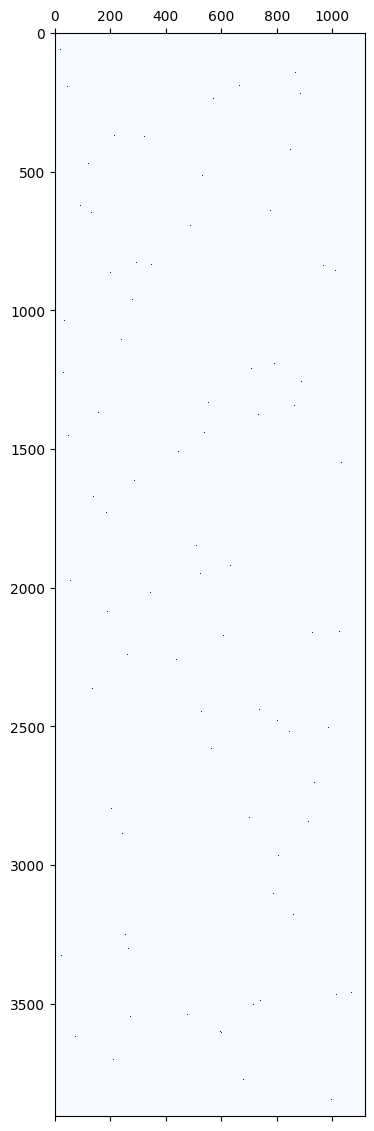

In [209]:
import pygmtools as pygm
import matplotlib.pyplot as plt

X = pygm.hungarian(D.cpu().numpy())
print(X)

plt.matshow(X, cmap='Blues')
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


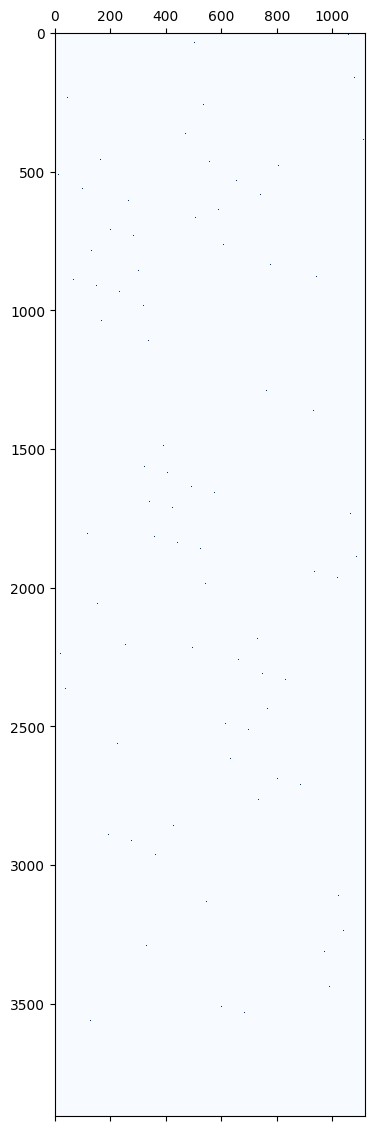

In [188]:
X = greedy_match(D)
X = X.todense()
print(X)

plt.matshow(X, cmap='Blues')
plt.show()

In [210]:
import numpy as np

def complete_to_square(matrix, pad_value=0):
    rows, cols = matrix.shape
    
    if rows == cols:
        # The matrix is already square
        return matrix
    
    # Determine the size of the new square matrix
    max_dim = max(rows, cols)
    
    # Create a new matrix with the pad_value
    square_matrix = np.full((max_dim, max_dim), pad_value)
    
    # Copy the original matrix into the top-left corner of the new square matrix
    square_matrix[:rows, :cols] = matrix
    
    return square_matrix

D_ = complete_to_square(D.cpu(), pad_value=1000000.5)
print(D_.shape)
D_ = torch.Tensor(D_)
D_

(3906, 3906)


tensor([[1.8017e+00, 1.3753e+00, 1.7637e+00,  ..., 1.0000e+06, 1.0000e+06,
         1.0000e+06],
        [2.2010e+00, 1.8911e+00, 2.3289e+00,  ..., 1.0000e+06, 1.0000e+06,
         1.0000e+06],
        [1.8073e+00, 1.3690e+00, 1.7995e+00,  ..., 1.0000e+06, 1.0000e+06,
         1.0000e+06],
        ...,
        [1.7043e+00, 1.2590e+00, 1.6889e+00,  ..., 1.0000e+06, 1.0000e+06,
         1.0000e+06],
        [1.0725e+00, 6.5264e-01, 1.0868e+00,  ..., 1.0000e+06, 1.0000e+06,
         1.0000e+06],
        [1.0203e+00, 6.1678e-01, 9.9863e-01,  ..., 1.0000e+06, 1.0000e+06,
         1.0000e+06]])

  0%|          | 3/3906 [00:00<07:00,  9.27it/s]

100%|██████████| 3906/3906 [02:46<00:00, 23.42it/s] 


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


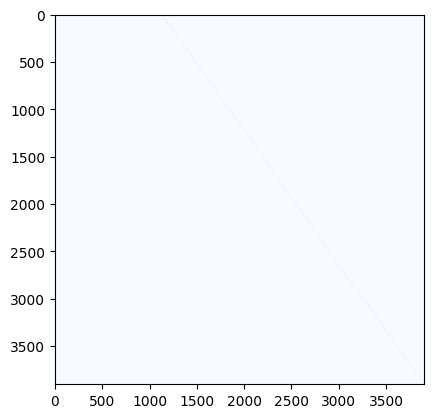

In [143]:
# Algorithm 1
""" def get_match(D, device):
    P = torch.zeros_like(D)
    size1, size2 = D.shape
    index_S = [i for i in range(size1)]
    index_S_hat = [i for i in range(size2)]
    
    for i in range(size1):
        try:    
            cur_size = D.shape[0]
            argmin = torch.argmin(D.to(device)).item()
            r = argmin // cur_size
            c = argmin % cur_size
            print(r, index_S[r], c, index_S_hat[c])
            
            
            P[index_S[r]][index_S_hat[c]] = 1
            index_S.remove(index_S[r])
            index_S_hat.remove(index_S_hat[c])
            D = D[torch.arange(D.size(0)) != r]
            D = D.t()[torch.arange(D.t().size(0)) != c].t()
        except:
            pass
    return P.t() """

def get_match(D, device):
    P = torch.zeros_like(D)
    size = D.shape[0] 
    index_S = [i for i in range(size)]
    index_S_hat = [i for i in range(size)]
    
    for i in tqdm(range(size)):
        cur_size = D.shape[0]
        argmin = torch.argmin(D.to(device)).item()
        r = argmin // cur_size
        c = argmin % cur_size
        P[index_S[r]][index_S_hat[c]] = 1
        index_S.remove(index_S[r])
        index_S_hat.remove(index_S_hat[c])
        D = D[torch.arange(D.size(0)) != r]
        D = D.t()[torch.arange(D.t().size(0)) != c].t()
    return P.t()

X = get_match(D_.T, device)
print(X)

plt.imshow(X.cpu().numpy(), cmap='Blues')
plt.show()

In [144]:
def hungarian(D): # much runtime
    print("0")
    P = torch.zeros_like(D)
    matrix = D.tolist()
    m = Munkres()
    print("1")
    indexes = m.compute(matrix)
    print("2")
    total = 0
    for r, c in tqdm(indexes):
        print(r)
        P[r][c] = 1
        total += matrix[r][c]
    return P.t()

# P = hungarian(D)

In [190]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def hungarian_algorithm(cost_matrix):
    # Use the linear_sum_assignment method from scipy
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Total cost
    total_cost = cost_matrix[row_ind, col_ind].sum()
    
    # The assignments are returned as (row, col) pairs
    assignments = list(zip(row_ind, col_ind))
    
    return total_cost, assignments

total_cost, assignments = hungarian_algorithm(D.cpu().numpy())

print(f"Total Cost: {total_cost}")
print(f"Assignments: {assignments}")

Total Cost: 128.3844451904297
Assignments: [(3, 749), (5, 372), (7, 662), (8, 535), (9, 20), (18, 340), (22, 910), (23, 327), (31, 542), (41, 67), (42, 7), (44, 822), (50, 384), (56, 638), (64, 101), (70, 581), (75, 162), (79, 647), (84, 279), (85, 791), (91, 124), (92, 743), (101, 809), (109, 856), (110, 303), (114, 326), (116, 880), (121, 554), (124, 493), (131, 1035), (133, 77), (135, 951), (139, 102), (145, 827), (146, 64), (147, 382), (150, 431), (151, 608), (152, 952), (154, 863), (157, 313), (158, 513), (159, 1036), (162, 391), (164, 574), (165, 33), (166, 98), (169, 775), (173, 937), (174, 812), (176, 355), (180, 1041), (183, 27), (187, 606), (188, 735), (193, 74), (194, 699), (198, 1104), (199, 332), (210, 277), (221, 988), (224, 950), (230, 753), (231, 525), (232, 1057), (239, 539), (240, 205), (241, 720), (243, 1021), (247, 771), (250, 846), (251, 255), (253, 216), (255, 171), (257, 1033), (266, 314), (269, 257), (270, 491), (272, 115), (275, 117), (278, 691), (283, 365), (2

(1118, 2)
[[   3  749]
 [   5  372]
 [   7  662]
 ...
 [3891 1030]
 [3892 1022]
 [3894  250]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


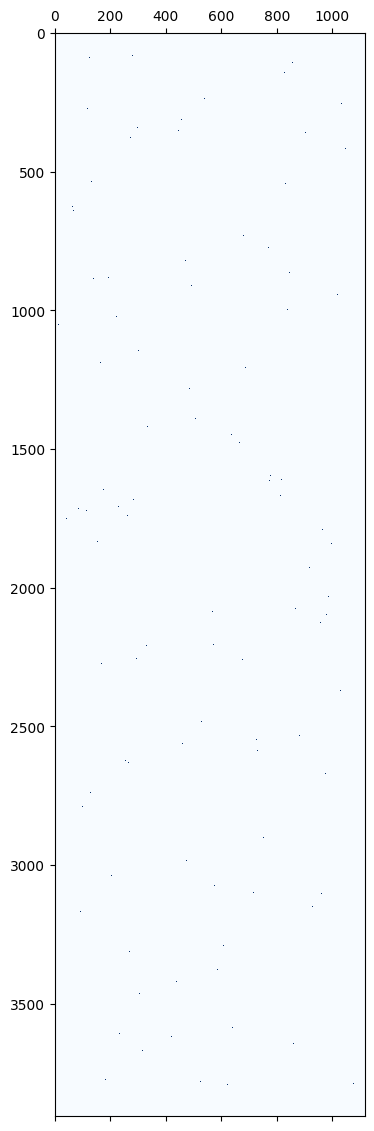

In [191]:
assignments_ = np.array(assignments)
print(assignments_.shape)
print(assignments_)

m, n = D.shape
matrix = np.zeros((m, n))

for i in range(min(m, n)):
    matrix[assignments_[i][0]][assignments_[i][1]] = 1

# a = assignments_[assignments_[:, 0].argsort()]
# a

print(matrix)

plt.matshow(matrix, cmap='Blues')
plt.show()

(1118, 2)
[[2890  902]
 [3866  270]
 [1883  889]
 ...
 [ 583  275]
 [3904  915]
 [2746  801]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


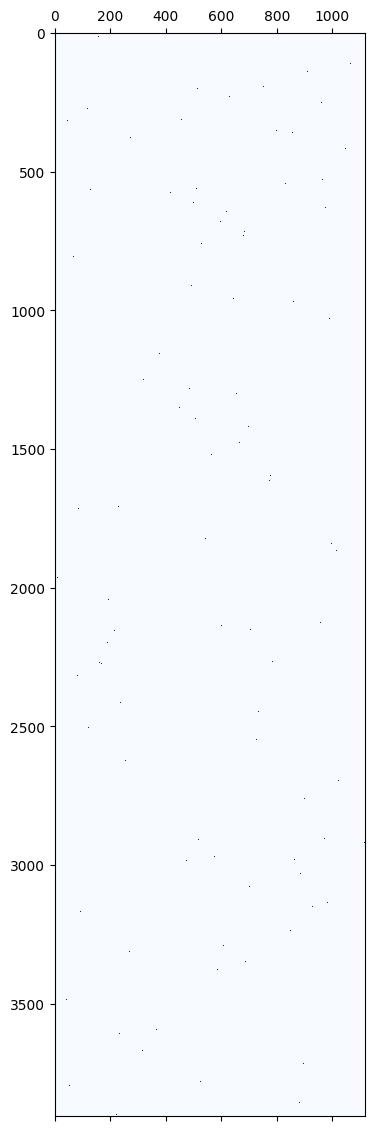

In [192]:
test_pairs_ = test_pairs.T
print(test_pairs_.shape)
print(test_pairs_)
# a = test_pairs_[test_pairs_[:, 0].argsort()] 
# a
m, n = D.shape
matrix = np.zeros((m, n))

for i in range(min(m, n)):
    matrix[test_pairs_[i][0]][test_pairs_[i][1]] = 1

# a = assignments_[assignments_[:, 0].argsort()]
# a

print(matrix)

plt.matshow(matrix, cmap='Blues')
plt.show()

In [168]:
print(test_idx)
test_pairs

[2890 3866 1883 ...  583 3904 2746]


array([[2890, 3866, 1883, ...,  583, 3904, 2746],
       [ 902,  270,  889, ...,  275,  915,  801]])

In [60]:
import torch
import torch.nn.functional as F

def sinkhorn(cost_matrix, num_iters=50, epsilon=1e-3):
    n = cost_matrix.shape[0]
    log_mu = torch.full((n,), -torch.log(torch.tensor(float(n))))
    log_nu = torch.full((n,), -torch.log(torch.tensor(float(n))))

    u = torch.zeros_like(log_mu)
    v = torch.zeros_like(log_nu)

    for _ in range(num_iters):
        u = log_mu - torch.logsumexp(-cost_matrix + v.view(1, -1), dim=1)
        v = log_nu - torch.logsumexp(-cost_matrix + u.view(-1, 1), dim=0)
    
    transport_plan = torch.exp(-cost_matrix + u.view(-1, 1) + v.view(1, -1))

    return transport_plan

def differentiable_hungarian_algorithm(cost_matrix, num_iters=50):
    # Apply the Sinkhorn algorithm to get the transport plan
    transport_plan = sinkhorn(cost_matrix, num_iters)
    
    # Apply hard threshold to get the binary assignment matrix
    assignment = transport_plan > 0.5
    
    # Calculate the total cost
    total_cost = (assignment * cost_matrix).sum()

    return total_cost, assignment

total_cost, assignment = differentiable_hungarian_algorithm(D)

print(f"Total Cost: {total_cost.item()}")
print(f"Assignment Matrix:\n{assignment}")


RuntimeError: The size of tensor a (1118) must match the size of tensor b (3906) at non-singleton dimension 1

In [155]:
matrix_match = []

for i in range(D.shape[0]):
    dist_list = D[i]
    sorted_neighbors = torch.argsort(dist_list).cpu()
    matrix_match.append([i, sorted_neighbors[0].item()])
matrix_match

[[0, 406],
 [1, 205],
 [2, 19],
 [3, 749],
 [4, 661],
 [5, 372],
 [6, 85],
 [7, 500],
 [8, 157],
 [9, 197],
 [10, 677],
 [11, 626],
 [12, 173],
 [13, 947],
 [14, 108],
 [15, 108],
 [16, 868],
 [17, 468],
 [18, 340],
 [19, 191],
 [20, 910],
 [21, 851],
 [22, 910],
 [23, 327],
 [24, 749],
 [25, 771],
 [26, 216],
 [27, 1077],
 [28, 520],
 [29, 973],
 [30, 167],
 [31, 542],
 [32, 691],
 [33, 671],
 [34, 516],
 [35, 352],
 [36, 398],
 [37, 248],
 [38, 905],
 [39, 120],
 [40, 96],
 [41, 512],
 [42, 7],
 [43, 548],
 [44, 822],
 [45, 96],
 [46, 919],
 [47, 1033],
 [48, 381],
 [49, 484],
 [50, 384],
 [51, 769],
 [52, 446],
 [53, 582],
 [54, 15],
 [55, 1064],
 [56, 285],
 [57, 466],
 [58, 600],
 [59, 306],
 [60, 732],
 [61, 494],
 [62, 928],
 [63, 383],
 [64, 101],
 [65, 518],
 [66, 747],
 [67, 638],
 [68, 848],
 [69, 33],
 [70, 581],
 [71, 251],
 [72, 139],
 [73, 344],
 [74, 100],
 [75, 162],
 [76, 173],
 [77, 293],
 [78, 985],
 [79, 192],
 [80, 639],
 [81, 285],
 [82, 559],
 [83, 875],
 [84, 2

---

In [ ]:
a = torch.tensor([[0.0,  0.0], [0.0, 1.0], [0.0,  2.0]])
print(a)
b = torch.tensor([[0.0, 1.0 ], [1.0,  1.0]])
print(b)
torch.cdist(a, b, p=2)

In [ ]:
a = torch.tensor([[4.01, 3.0, 2.0, 0.1, 4.0]])
print(a)
torch.argsort(a, dim=1)

In [53]:
a = np.array([[9, 2, 3],[4, 5, 6],[7, 0, 5]])
print(a)

a = a[a[:, 2].argsort()] 

print(a)

[[9 2 3]
 [4 5 6]
 [7 0 5]]
[[9 2 3]
 [7 0 5]
 [4 5 6]]
